In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('C:/Users/Pyoyj/Downloads/data/train/train.csv')

In [27]:
train.head(5)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


In [43]:
# 일단 RH로 해봄.. 변수 연관성검사 해보고 일일이 넣어야 하나? 하나하나?
mod = smf.quantreg('TARGET~DHI', train)
res = mod.fit(q=0.5)
res.summary()

#for i in range(1, 10):
#    s1 = "res_%d = mod.fit(q=%d)"%(i, i/10)
#    exec(s1)

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                 TARGET   Pseudo R-squared:               0.4258
Model:                       QuantReg   Bandwidth:                      0.5203
Method:                 Least Squares   Sparsity:                        1.325
Date:                Sun, 27 Dec 2020   No. Observations:                52560
Time:                        09:54:58   Df Residuals:                    52558
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.08e-07      0.003   6.12e-05      1.000      -0.007       0.007
DHI            0.1649   2.78e-05   5929.909      0.000       0.165       0.165
==============================================================================
"""

In [44]:
res.conf_int()

,0,1
Intercept,-0.006661,0.006661
DHI,0.164846,0.164955


In [52]:
quantiles = np.arange(.1, 1, .1)
def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'], res.params['DHI']] + res.conf_int().loc['DHI'].tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns = ['q', 'a', 'b', 'lb', 'ub',])

ols = smf.ols('TARGET~DHI', train).fit()

In [53]:
ols_ci = ols.conf_int().loc['DHI'].tolist() #99아니고 95퍼겠지..?
ols = dict(a = ols.params['Intercept'], b= ols.params['DHI'], lb = ols_ci[0], ub = ols_ci[1])
print(models)
print(ols)

     q             a         b        lb        ub
0  0.1 -7.209037e-07  0.099296  0.099255  0.099338
1  0.2 -1.273410e-07  0.104647  0.104570  0.104723
2  0.3  3.102005e-08  0.118156  0.118046  0.118267
3  0.4  1.083427e-07  0.138873  0.138778  0.138968
4  0.5  2.080400e-07  0.164901  0.164846  0.164955
5  0.6  3.575589e-07  0.193930  0.193910  0.193950
6  0.7  5.326538e-07  0.258197  0.258192  0.258203
7  0.8  6.038007e-07  0.450713  0.450683  0.450743
8  0.9  6.194569e-07  0.708035  0.707994  0.708077
{'a': 7.151247734203169, 'b': 0.16535127040238726, 'lb': 0.163771775905361, 'ub': 0.16693076489941353}


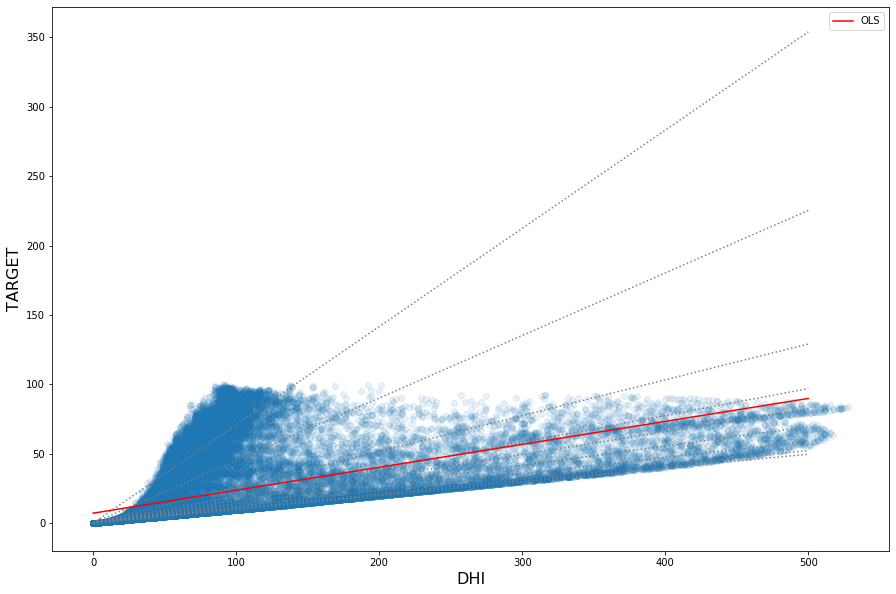

In [61]:
x = np.arange(train.DHI.min(), train.DHI.max(), 50)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(15, 10))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i]) #각 퀀타일별 회귀식 구하기. intercept(=a) + b*x 
    ax.plot(x, y, linestyle='dotted', color='grey')

y = get_y(ols['a'], ols['b']) # 얘는 퀀 0.5인 애...

ax.plot(x, y, color='red', label='OLS')
ax.scatter(train.DHI, train.TARGET, alpha=.1)
legend = ax.legend()
ax.set_xlabel('DHI', fontsize=16)
ax.set_ylabel('TARGET', fontsize=16); #ㅋㅋ난리났죠;; 데이터가 너무많네

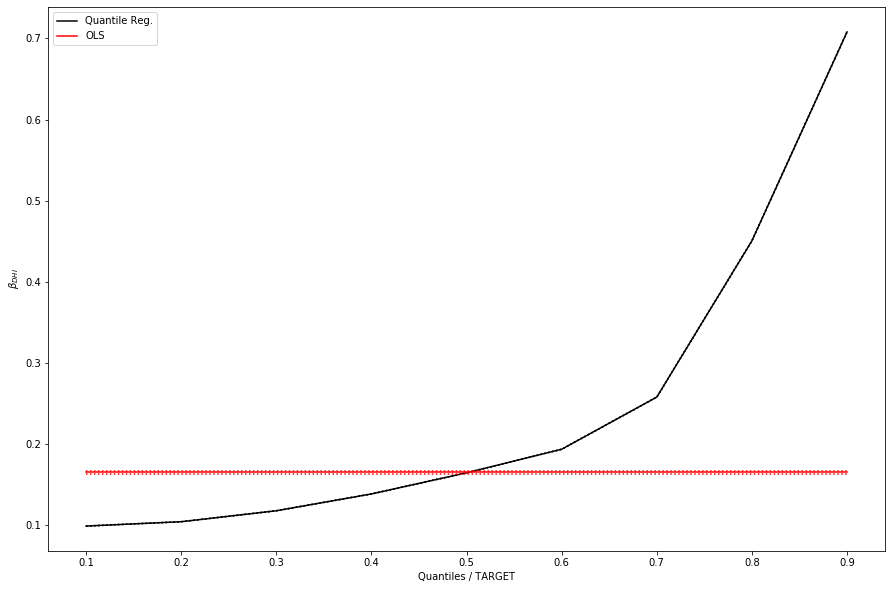

In [66]:
n = models.shape[0]
p1 = plt.plot(models.q, models.b, color = 'black', label = 'Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle = 'dotted', color = 'black')
p3 = plt.plot(models.q, models.lb, linestyle = 'dotted', color = 'black' )
p4 = plt.plot(models.q, [ols['b']]*n, color = 'red', label = 'OLS')
p5 = plt.plot(models.q, [ols['lb']]*n, linestyle = 'dotted', color = 'red')
p6 = plt.plot(models.q, [ols['ub']]*n, linestyle = 'dotted', color = 'red')

plt.ylabel(r'$\beta_{DHI}$')
plt.xlabel('Quantiles / TARGET')
plt.legend()
plt.rcParams["figure.figsize"] = (20, 10)
plt.show()
#? 신뢰구간 다 어디감... 그림문제인가.. 아무튼...

In [67]:
# 얘는 지금 train데이터- DHI/TARGET만 가지고 만든 거고. 그럼.. test 81개파일 불러와서...
# 근데 그러려면 7, 8일차의 DHI값을 알아야 TARGET이 나오는 거잖아
# 다항회귀로 하고 싶다 / 변수 조합 / train 내 무작위 연속7개->다음 두개

import sklearn.preprocessing as pp
poly2 = pp.PolynomialFeatures(degree = 2)

In [71]:
train['Time'] = train['Hour']+train['Minute']/60

In [74]:
train.drop(['Hour', 'Minute'], axis = 1, inplace = True)

In [77]:
train = train[['Time', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET']]

In [89]:
pip install --upgrade patsy

Requirement already up-to-date: patsy in c:\users\pyoyj\anaconda3\lib\site-packages (0.5.1)
Note: you may need to restart the kernel to use updated packages.


PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'DHI' is not defined
    TARGET ~ 1 + DHI + I(DHI ** 2.0)
                 ^^^

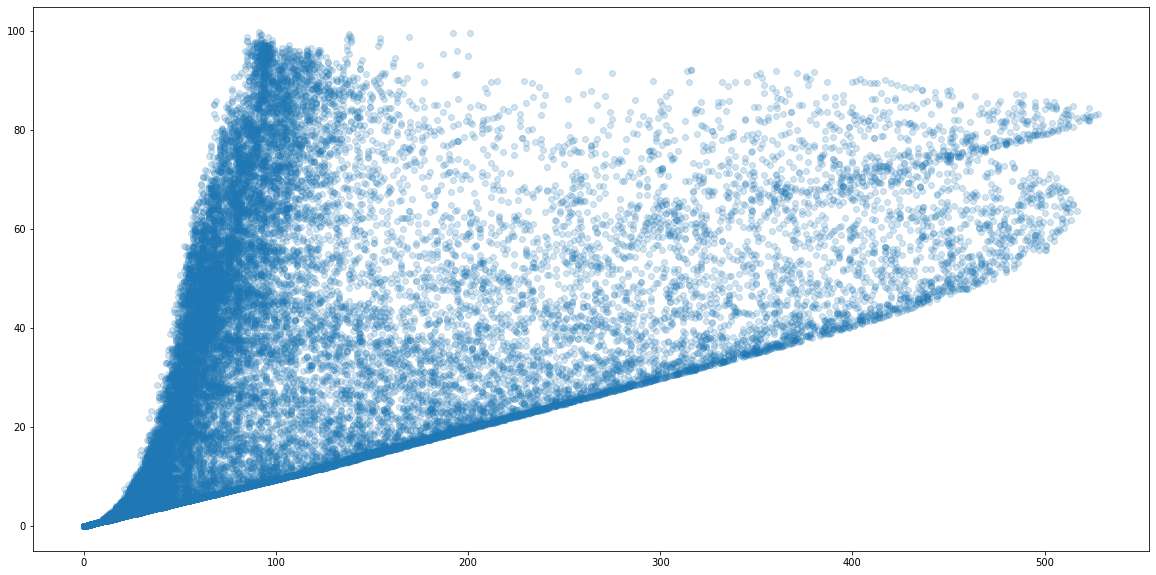

In [90]:
# d = {'DHI': x, 'TARGET': y}
#df = pd.DataFrame(data = d) 굳이??

x1 = pd.DataFrame(np.linspace(train.DHI.min(), train.DHI.max(), 200))

poly_2 = smf.ols('TARGET ~ 1 + DHI + I(DHI ** 2.0)', train).fit()
plt.plot(train.DHI, train.TARGET, 'o', alpha=0.2)
plt.plot(train.DHI, poly_2.predict(x1), 'r-', label='2nd order poly fit, $R^2$=%.2f' % poly_2.rsquared, alpha=0.9)
plt.xlim((-10, 50))
plt.ylim((0, 0.25))
plt.xlabel('DHI')
plt.ylabel('TARGET')
plt.legend(loc="upper left")


# with quantile regression

# Least Absolute Deviation
# The LAD model is a special case of quantile regression where q=0.5

mod = smf.quantreg('TARGET ~ DHI + I(DHI ** 2.0)', train) #DHI가 없다니 무슨소리요??
res = mod.fit(q=.5)
print(res.summary())

# Quantile regression for 5 quantiles

quantiles = np.arange(.1, 1, .1)
# get all result instances in a list
res_all = [mod.fit(q=q) for q in quantiles]

res_ols = smf.ols('TARGET ~ DHI + I(DHI ** 2.0)', train).fit()


plt.figure()

# create x for prediction
x_p = np.linspace(train.DHI.min(), train.DHI.max(), 50)
df_p = pd.DataFrame({'DHI': x_p})

for qm, res in zip(quantiles, res_all):
    # get prediction for the model and plot
    # here we use a dict which works the same way as the df in ols
    plt.plot(x_p, res.predict({'DHI': x_p}), linestyle='--', lw=1, color='k', label='q=%.2F' % qm, zorder=2)

y_ols_predicted = res_ols.predict(df_p)
plt.plot(x_p, y_ols_predicted, color='red', zorder=1)
#plt.scatter(df.temp, df.dens, alpha=.2)
plt.plot(df.temp, df.dens, 'o', alpha=.2, zorder=0)
plt.xlim((-10, 50))
plt.ylim((0, 0.25))
#plt.legend(loc="upper center")
plt.xlabel('DHI')
plt.ylabel('TARGET')
plt.title('')
plt.show()